In [2]:
using PyPlot
include("saltsolver.jl")

/Users/davidliu/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


smallest_stability_eigs (generic function with 1 method)

In [3]:
nsym = 8
ℓ = 2
Lcav = 1.37

wantcnv = true
if wantcnv
    ɛrpiece = [1.0, 1.1, 1.1]
    ɛipiece = [0.3, 0.25, 0.25]
    Fpiece = [1.1, 0.9, 0.9]
else 
    ɛrpiece = [1.0, 1.2, 1.1]
    ɛipiece = [0.3, 0.25, 0.32]
    Fpiece = [1.1, 0.9, 0.95]
end
    
ɛr = cn_profile(ɛrpiece, nsym)
ɛi = cn_profile(ɛipiece, nsym)
ɛ = ɛr + im*ɛi
F = cn_profile(Fpiece, nsym)

ismirror(v) = (v == ring_flip(v))
iscnv = (ismirror(ɛ) && ismirror(F))
assert(wantcnv == iscnv)

N = length(F)
h = Lcav / N
laplacian!(J) = periodic!(J, h)
Eguess, ωguess = ring_eigenpair(N, ℓ, h)

# purposely make it far from gain center to 
# see low-Q effects
ωa = round(ωguess) + 1
γ⟂ = 0.7
γpar = 0.1
las = Laser(ɛ, F, ωa, γ⟂);

In [4]:
Dguess = 1.5* mean(ɛipiece)
md = Mode(copy(Eguess), ωguess, 0.0)
Dt = threshold!(laplacian!, md, las, (Dguess, Dguess*1.05))

println("threshold search slightly breaks pure chirality")
println("use projection operator to get it back")
md = Mode(project_chiral(md.E, nsym, ℓ), md.ω, md.c²)
println("chiral-projected mode should automatically be solution")
solve!(laplacian!, md, las, Dt, isprint=true)
println("ℓ eigenvalue and residual:\n", get_ell(md.E, nsym))

fmd = mode_flip(md)
if iscnv
    println("Cnv, so flipped solved immediate")    
else
    println("Cn only, so flipped solve not immediate")
end
solve!(laplacian!, fmd, las, Dt, isprint=true)
if !iscnv
    fmd = Mode(project_chiral(fmd.E, nsym, -ℓ), fmd.ω, fmd.c²)
    println("reprojecting fmd to fix slightly broken chiral symmetry")
    println("reprojected fmd should immediately solve Newton")
    solve!(laplacian!, fmd, las, Dt, isprint=true)
end
println("ℓ eigenvalue and residual:\n", get_ell(fmd.E, nsym))

println("\ncheck that degenerate and at threshold")
println("ω₊ - ω₋ = ", md.ω - fmd.ω)
println("|c₊²|+|c₋²| = ", abs(md.c²) + abs(fmd.c²))
Es = (md.E, fmd.E)
ωt = md.ω
H, I, J, K, GD = overlap_integrals(Es, ωt, Dt, las, nsym, ℓ, Lcav);

threshold search slightly breaks pure chirality
use projection operator to get it back
chiral-projected mode should automatically be solution
|f| = 1.0414826611447099e-9
ℓ eigenvalue and residual:
(2.0,2.663215124191999e-16)
Cnv, so flipped solved immediate
|f| = 1.0414576881842615e-9
ℓ eigenvalue and residual:
(-2.0000000000000004,2.8333756983454306e-16)

check that degenerate and at threshold
ω₊ - ω₋ = 0.0
|c₊²|+|c₋²| = 1.1519969446704563e-10


In [5]:
# CIRCULATING MODES
ω1s = [0.0, 0.0]
a²ths = [0.0, 0.0]
for m in (1, 2)
    ω1s[m] = -imag(GD / I[m]) / imag(H / I[m])
    a²ths[m] = real((ω1s[m]*H+GD) / I[m])
end

m = 2
d = 0.0001
Dlasing = Dt*(1+d)
a² = a²ths[m]
ω1 = ω1s[m]
md = Mode(copy(Es[m]), ωt+ω1*d, d * a²)
solve!(laplacian!, md, las, Dlasing, isprint=true)
Esalt = √md.c² * md.E
ωsalt = md.ω

println("expected a² = ", a²)
println("actual   a² = ", md.c² / d)
println("expected ω1 = ", ω1)
println("actual   ω1 = ", (md.ω-ωt)/d)

println("\n theoretical stability eigenvalues:")
imjh = imag(J[m]/H)
term = (abs(K[m])^2 - abs(J[m])^2) / abs(H)^2
other_val(z) = a²*(imjh + z*√(0.0im + imjh^2 + term))
println(0.0)
println(other_val(1))
println(other_val(-1))
println(2a² * imag(I[m] / H))

println("\nnumerical stability eigenvalues")
Λsmallest = smallest_stability_eigs(laplacian!, Esalt, ωsalt, Dlasing, γpar, las.ɛ)
for λ in Λsmallest
    println(λ / d)
end

|f| = 0.0002405703663647581
|f| = 3.8228657406120364e-13
expected a² = 1.0130676907729914
actual   a² = 1.013068476969252
expected ω1 = 6.998553203308449e-6
actual   ω1 = 6.998579493711077e-6

 theoretical stability eigenvalues:
0.0
-0.6248123155826234 + 0.13035966494684315im
-0.6248123155826234 - 0.13035966494684315im
-1.2496246311652468

numerical stability eigenvalues
7.620026134931075e-10 + 0.0im
-0.625166229441428 + 0.1304977709717101im
-0.625166229441428 - 0.1304977709717101im
-1.2512111725618833 + 0.0im


n = 4|ℓ|; expecting zeros at mπ/2 exactly because Cnv
a² differs across roots because ±i and ±1 solutions
standing lasing mode E = |a₊|E₊ exp(iθ)|a₋|E₋
θ1 = -1.0 × π/2
ω1[1] = 0.0001401849840449582
  |a₊|²[1] = 0.34196629711450466
  |a₋|²[1] = 0.34196629711450477
θ2 = 0.0 × π/2
ω1[2] = -0.00012289743323769568
  |a₊|²[2] = 0.3335178307019262
  |a₋|²[2] = 0.3335178307019262
θ3 = 0.9999999999999996 × π/2
ω1[3] = 0.00014018498404501126
  |a₊|²[3] = 0.3419662971145046
  |a₋|²[3] = 0.34196629711450477
θ4 = 2.0000000000000004 × π/2
ω1[4] = -0.00012289743323769568
  |a₊|²[4] = 0.3335178307019262
  |a₋|²[4] = 0.3335178307019262
|a₊|²=|a₋|² because mirror symmetry


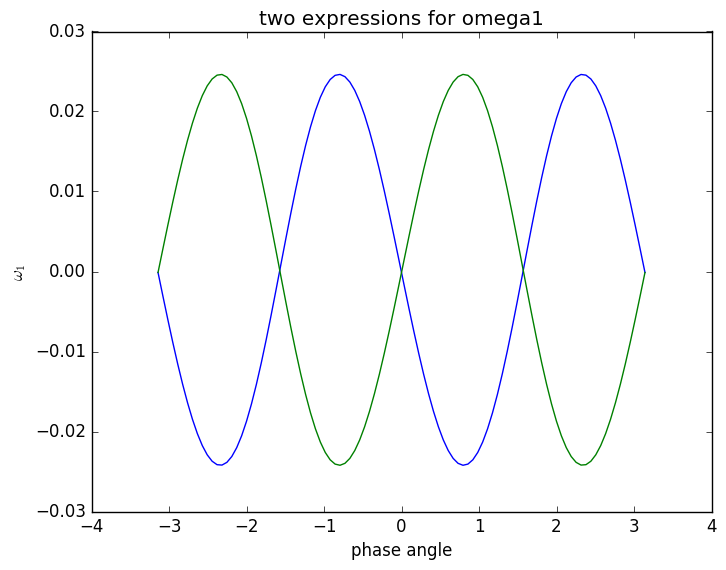

([-1.5707963267948966,0.0,1.570796326794896,3.1415926535897936],[0.0001401849840449582,-0.00012289743323769568,0.00014018498404501126,-0.00012289743323769568],[(0.34196629711450466,0.34196629711450477),(0.3335178307019262,0.3335178307019262),(0.3419662971145046,0.34196629711450477),(0.3335178307019262,0.3335178307019262)])

In [6]:
# get standing mode allowed phases
θroots, ω1roots, a²standing = standing_roots_test(H, I, J, K, GD, iscnv, nsym, ℓ)

In [12]:
mroot = 2
d = 0.0001
Dlasing = Dt * (1+d)
a²s = a²standing[mroot]
θroot = θroots[mroot]
Esalt_guess = √a²s[1] * Es[1] + exp(im*θroot) * √a²s[2] * Es[2]
ωsalt_guess = ωt + d * ω1roots[mroot]
md = Mode(copy(Esalt_guess), ωsalt_guess, 0.0)
c²guess = d * norm(Esalt_guess)^2 / norm(md.E)^2
md.c² = c²guess
solve!(laplacian!, md, las, Dlasing, isprint=true)
coefs = √md.c² * collect(coefficients( md.E, Es))
Esalt = √md.c² * md.E
ωsalt = md.ω
println("expected c² = ", c²guess)
println("actual   c² = ", md.c²)

println("expected ω1 = ", ω1roots[mroot])
println("actual   ω1 = ", (md.ω - ωt)/d)
for m in (1, 2)
    println("coefficient |a_", m, "|^2:")
    println("\texpected: ", a²s[m])
    println("\tactual:   ", abs(coefs[m])^2/d)
end
println("expected θ = ", θroot)
println("actual   θ = ", angle(coefs[2]/coefs[1]))

println("\nnumerical stability eigenvalues")
Λsmallest = smallest_stability_eigs(laplacian!, Esalt, ωsalt, Dlasing, γpar, las.ɛ)
for λ in Λsmallest
    println(λ / d)
end

println("\ntheoretical stability eigenvalues")
z = exp(im*θroot)
a₊a₋ = sqrt(a²s[1]*a²s[2])
a₊², a₋² = a²s 
# be careful to either say 1 + 1 or 1+1 here, not 1 +1 or else
# it will get interpreted as the next column!
XQmP̃ = [2a₋²*K[2]*z^2   a₊a₋*((z-1/z)*(I[2]+J[2]) - 2z*K[2]) ;
        -2a₊a₋/z*K[1]       a₋²*(z^2-1)*I[2] + a₊²*K[1]*(1+z^-2)     ]
XQpP̃ = [2a₊²*I[1]      a₊a₋*((z+1/z)*(I[2]+J[2]) + 2z*K[2]); 
    2a₊a₋*(z*(I[1] + J[1]) + 1/z*K[1])    a₋²*(z^2+1)*I[2] + a₊²*K[1]*(1-z^-2)] 
MatFinal = [ imag(XQpP̃/H)   -real(XQmP̃/H);
            -real(XQpP̃/H)  -imag(XQmP̃/H) ]

Λfinal, ~ = eig(MatFinal)
Λfinal = Λfinal[sortperm(abs(Λfinal))]
for λ in Λfinal
    println(λ)
end

i₊, i₋ = I[1]/H, I[2]/H
j₊, j₋ = J[1]/H, J[2]/H
k₊, k₋ = K[1]/H, K[2]/H
zr, zi = real(z), imag(z)
MatFinalAlternate_first2cols = 
2*[ a₊² * imag(i₊)      a₊a₋*(zr*imag(i₋ + j₋) + imag(z*k₋));
    a₊a₋*imag(z*(i₊ + j₊)+1/z*k₊)     a₋²*zr*imag(z*i₋) + a₊²*real(1/z*k₊)*zi;
    -a₊² * real(i₊)      -a₊a₋*(zr*real(i₋+j₋) + real(z*k₋));
    -a₊a₋*real(z*(i₊+j₊)+1/z*k₊)    -a₋²*zr*real(z*i₋) + a₊²*imag(1/z*k₊)*zi]
MatFinalAlternate_second2cols = 
2*[ -a₋²*real(k₋*z^2)   a₊a₋*(zi*imag(i₋+j₋) + real(z*k₋));
    a₊a₋*real(1/z*k₊)   a₋²*zi*imag(z*i₋) - a₊²*real(1/z*k₊)*zr;
    -a₋²*imag(k₋*z^2)   -a₊a₋*(zi*real(i₋+j₋) - imag(z*k₋));
    a₊a₋*imag(1/z*k₊)   -a₋²*zi*real(z*i₋) - a₊²*imag(1/z*k₊)*zr]
MatFinalAlternate = [MatFinalAlternate_first2cols  MatFinalAlternate_second2cols]
println("\nnorm(MatFinal - MatFinalAlternate) = ", norm(MatFinalAlternate - MatFinal))


if nsym==4abs(ℓ) && iscnv
    println("\nclosed-form theoretical predictions for Cnv with n==4ℓ:")
    isrealz = iseven(round(Int, θroot/(π/2)))
    println("standing solution with z = ", isrealz ? "±1" : "±i")
    vals = [0.0, 0.0, 0.0, 0.0]
    vals[1] = 0.0
    
    α = isrealz ? 1 : -1
    # I have no idea what to name this!
    
    vals[2] = 2a₊² * imag(2i₊ + j₊ + α*k₊)
    radicand = imag(k₊ - α * j₊)^2 - α * 8real(k₊)*real(j₊ + α * k₊)    
    vals[3] = -a₊² * imag(j₊ + α * 3k₊) + a₊² * √radicand
    vals[4] = -a₊² * imag(j₊ + α * 3k₊) - a₊² * √radicand
    abslt(x, y) = abs(x) < abs(y)
    sort!(vals, lt=abslt)
    for λ in vals
        println(λ)
    end
    
    if isrealz
        for sn in (1, -1)
            Mat = a₊² * [2imag(i₊)   2sn*imag(i₋+j₋+k₋)   -√2*real(k₋);
                2sn*imag(i₊+j₊+k₊)    2imag(i₋)         √2*sn*real(k₊);
                √2*real(j₊+k₊)       -√2*sn*real(j₋+k₋)  -imag(k₋)-imag(k₊)]
            vals, ~ = eig(Mat)
            sort!(vals, lt=abslt)
            println("theoretical eigenvalues from 3x3 problem for sign = ", sn)
            for λ in vals
                println("\t", λ)
            end
        end
    end
    
elseif iscnv && nsym!=4abs(ℓ)
    println("\nclosed-form theoretical predictions for Cnv with n!=4ℓ:")    
    println("two nonzero eigenvalues")
    vals = [0.0, 0.0]
    ss = [1, -1]
    tr0 = 2imag(a₊² * i₊ + a₋² * i₋)
    det0 = -4a₊a₋^2*(imag(i₊)*imag(j₋) + imag(j₊)*imag(i₋) + imag(j₊)*imag(j₋))
    for m = (1, 2)
        vals[m] = tr0/2 + ss[m] * sqrt((tr0/2)^2 - det0)
    end
    for λ in vals
        println(λ)
    end
end

|f| = 0.0031897101292796236
|f| = 2.9982065976415324e-13
expected c² = 0.00012882929215343603
actual   c² = 0.00012883079733359856
expected ω1 = -0.00012289743323769568
actual   ω1 = -0.00012258974280143775
coefficient |a_1|^2:
	expected: 0.3335178307019262
	actual:   0.3335211051190766
coefficient |a_2|^2:
	expected: 0.3335178307019262
	actual:   0.33352110512119637
expected θ = 0.0
actual   θ = 2.798197072196322e-11

numerical stability eigenvalues
-1.7676817457603425e-10 + 0.0im
0.032266340928185644 + 0.0im
0.4254301744060616 + 0.0im
-1.2511993399189727 + 0.0im

theoretical stability eigenvalues
1.6084936184278962e-18
0.032252019371318864
0.42545308077422
-1.2496246311652486

norm(MatFinal - MatFinalAlternate) = 8.461802603816965e-17

closed-form theoretical predictions for Cnv with n==4ℓ:
standing solution with z = ±1
0.0
0.03225201937131886
0.4254530807742194
-1.249624631165247
theoretical eigenvalues from 3x3 problem for sign = 1
	0.016098886435951424
	0.42616988005066586
	-1.249